In [1]:
## Importing Libraries ##

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


## Adjusting Figure Size ##

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 12
fig_size[1] = 6
plt.rcParams.update({'font.size':12})


In [2]:
""" getData() Function when called, returns a dataframe with desired columns and somewhat cleaned rows """

def getData():    
    ## Pulling the data ##
    url = 'https://data.cityofnewyork.us/api/views/h9gi-nx95/rows.csv?accessType=DOWNLOAD' 
    df = pd.read_csv(url, na_values=['','                                '])

    ## Formating the Date ##
    df['DATE'] = pd.to_datetime(df['DATE'], format='%m/%d/%Y')
    df = df.sort_values(by='DATE')
    
    ## Filtering the Desired Date Range - 2013 to 2016 ##
    df = df[df.DATE>='01/01/2013']
    df = df[df.DATE<'01/01/2017']
    df = df.reset_index(drop=True)

    return df

""" getFeatures() Function when called, returns a dataframe with additional features."""
def getFeatures(df):
    ## Takes unstructured Zip Code data [some are int and some are in string format] and formats them evenly##
    df['ZIP CODE'] = df['ZIP CODE'].apply(str)
    df['ZIP CODE'] = df['ZIP CODE'].str.split('.',expand=True)[0]
    
    ## Creating New Features using the Date Column ##
    df["YEAR"] = df["DATE"].dt.year
    df["MONTH"] = df["DATE"].dt.month
    df["DAY"] = df["DATE"].dt.day
    df["WEEKDAY"] = df["DATE"].dt.weekday
    df["TIME2"] = pd.to_datetime(df['TIME'], format='%H:%M')
    df["HOUR"] = df["TIME2"].dt.hour
    del df['TIME2']
    
    ## Based on Day, Month and Hour Features, We created additional features such as season, weekend, workhour etc. ##
    df["wdayStatus"]="Weekday"
    df["wdayStatus"].ix[df['DAY'] >4] = "Weekend"
    df["monthStatus"] = "Fall"
    df.loc[(df["MONTH"] < 3) | (df["MONTH"] >= 12), "monthStatus"]="Winter"
    df.loc[(df["MONTH"] < 6) & (df["MONTH"] >= 3), "monthStatus"]="Spring"
    df.loc[(df["MONTH"] < 9) & (df["MONTH"] >= 6), "monthStatus"]="Summer"
    
    df["hourStatus"] = "Evening"
    df.loc[(df["HOUR"] < 18) & (df["wdayStatus"] == "Weekday"), "hourStatus"]="WorkHour"
    df.loc[(df["HOUR"] < 7) & (df["wdayStatus"] == "Weekday"), "hourStatus"]="Night"
    df.loc[(df["HOUR"] < 16) & (df["wdayStatus"] == "Weekend"), "hourStatus"]="Day"
    df.loc[(df["HOUR"] < 7) & (df["wdayStatus"] == "Weekend"), "hourStatus"]="Night"
    
    df['TotalDeathsInjuries'] = df['NUMBER OF PERSONS INJURED']+df['NUMBER OF PERSONS KILLED']
    del df['UNIQUE KEY']
    
    ## Created this Column for Counting Purposes ##
    df['Ref'] = 1
    return df

""" getRatio() Function when called, returns a dataframe with summary statistics by zip code"""
def getRatio(df):
    df2 = df.groupby(['ZIP CODE'],as_index=False)['TotalDeathsInjuries'].sum()
    df3 = df.groupby(['ZIP CODE'],as_index=False)['Ref'].sum()
    df4 = pd.merge(df3,df2)
    df4['Ratio'] = df4.TotalDeathsInjuries/df4.Ref
    return df4

""" getMissing() Function when called, returns a dataframe with missing data percentage by feature and plots it"""

def getMissing(df):
    missing_var = 100*df.isnull().sum()/df.shape[0]
    missing_var.sort()
    print(100*df.isnull().sum()/df.shape[0]) #missing_var2.index
    plot = missing_var.plot(kind='barh',figsize=(14,12), grid = False,label="Percentage",color='lightgreen',fontsize=12)
    plot.set_xlabel("% of Missing Values in Data")
    plt.figtext(.5,0.9,'Missingness of Data By Variable',fontsize=30,ha='center')

    return missing_var


In [3]:
df = getData() ## loading the data

C:\Users\uygur\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2821: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [4]:
df2 = getFeatures(df.copy()) ##getting missing data info and plotting it


C:\Users\uygur\Anaconda3\lib\site-packages\pandas\core\indexing.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


C:\Users\uygur\Anaconda3\lib\site-packages\ipykernel\__main__.py:67: FutureWarning: sort is deprecated, use sort_values(inplace=True) for INPLACE sorting


DATE                              0.000000
TIME                              0.000000
BOROUGH                          26.311395
ZIP CODE                         26.317476
LATITUDE                         21.279358
LONGITUDE                        21.279358
LOCATION                         21.279358
ON STREET NAME                   18.909696
CROSS STREET NAME                21.702349
OFF STREET NAME                  85.107958
NUMBER OF PERSONS INJURED         0.000000
NUMBER OF PERSONS KILLED          0.000000
NUMBER OF PEDESTRIANS INJURED     0.000000
NUMBER OF PEDESTRIANS KILLED      0.000000
NUMBER OF CYCLIST INJURED         0.000000
NUMBER OF CYCLIST KILLED          0.000000
NUMBER OF MOTORIST INJURED        0.000000
NUMBER OF MOTORIST KILLED         0.000000
CONTRIBUTING FACTOR VEHICLE 1     0.438896
CONTRIBUTING FACTOR VEHICLE 2    12.393507
CONTRIBUTING FACTOR VEHICLE 3    93.437851
CONTRIBUTING FACTOR VEHICLE 4    98.581103
CONTRIBUTING FACTOR VEHICLE 5    99.655012
UNIQUE KEY 

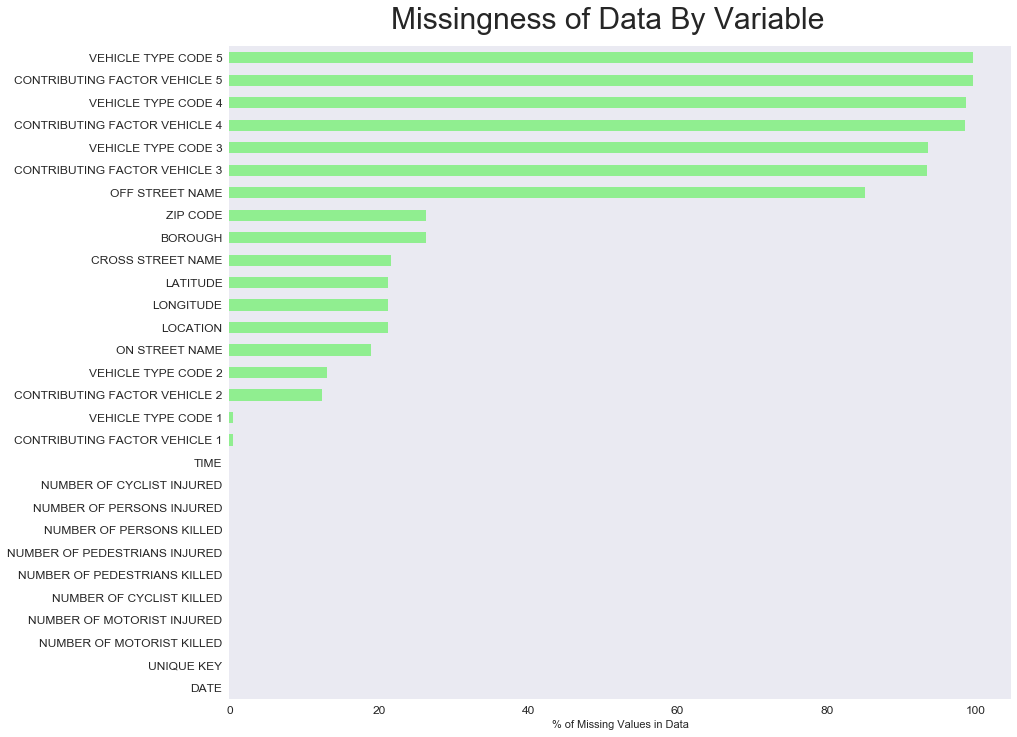

In [5]:
missing_var = getMissing(df) ## 

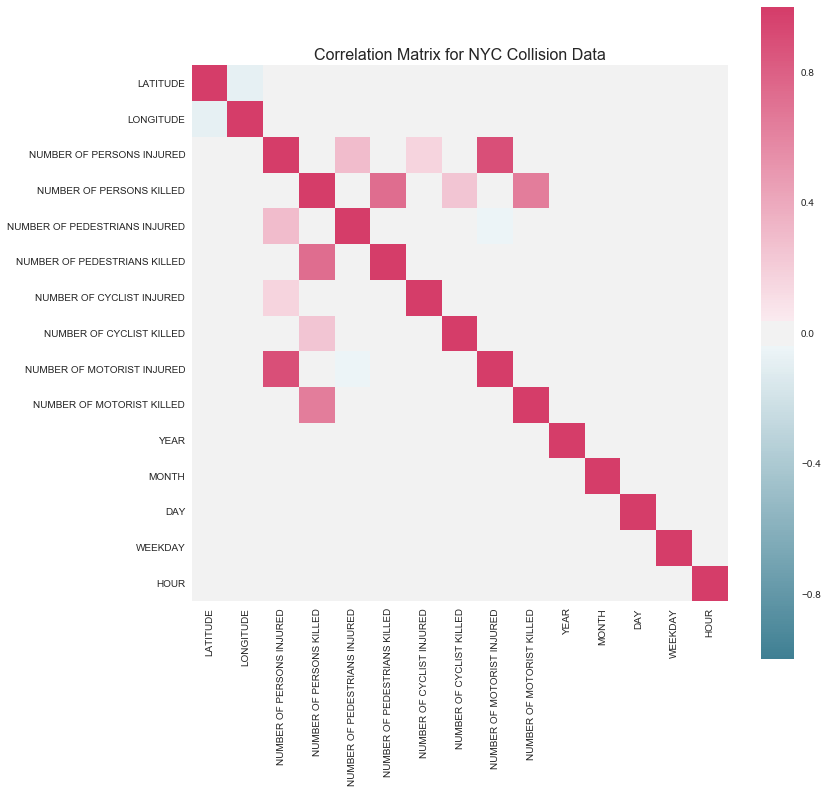

In [6]:
## Selecting some categories to conduct correlation anaylsis ##
col2Use = ['LATITUDE', 'LONGITUDE',
       'NUMBER OF PERSONS INJURED', 'NUMBER OF PERSONS KILLED',
       'NUMBER OF PEDESTRIANS INJURED', 'NUMBER OF PEDESTRIANS KILLED',
       'NUMBER OF CYCLIST INJURED', 'NUMBER OF CYCLIST KILLED',
       'NUMBER OF MOTORIST INJURED', 'NUMBER OF MOTORIST KILLED',
       'YEAR', 'MONTH', 'DAY', 'WEEKDAY', 'HOUR']
f, ax = plt.subplots(figsize=(12,12))
corr = df2[col2Use].corr(method='pearson')
sns.heatmap(corr, cmap=sns.diverging_palette(220, 0, as_cmap=True),
            square=True, ax=ax)
ax.set_title('Correlation Matrix for NYC Collision Data',size=16)


In [7]:
df3 = getRatio(df2) ## getting ZIp code statistics.

In [8]:
df3.head(3)
df3.to_csv("data/ratio.csv",index=False)

In [9]:
df2.head(3)
df2.to_csv("data/TableauMain.csv",index=False)